<a href="https://colab.research.google.com/github/stuser/temp/blob/master/pneumoniamnist_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import package
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation, GlobalAveragePooling2D,
                    BatchNormalization, Flatten, Conv2D, MaxPooling2D)

In [3]:
#需安裝google download套件, Google Drive direct download of big files.
#pip install gdown

In [4]:
tf.__version__

'2.3.0'

In [5]:
#確認CPU&GPU裝置狀況
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3444100775165552065
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8255064824492255817
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11901223179687741234
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695241536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8955539853249983475
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


### MedMNIST
MedMNIST, a collection of 10 pre-processed medical open datasets. MedMNIST is standardized to perform classification tasks on lightweight 28 * 28 images, which requires no background knowledge. Covering the primary data modalities in medical image analysis, it is diverse on data scale (from 100 to 100,000) and tasks (binary/multi-class, ordinal regression and multi-label). MedMNIST could be used for educational purpose, rapid prototyping, multi-modal machine learning or AutoML in medical image analysis. Moreover, MedMNIST Classification Decathlon is designed to benchmark AutoML algorithms on all 10 datasets.
(著者: 上海交通大學 Jiancheng Yang, Rui Shi, Bingbing Ni, Bilian Ke)

[GitHub Pages 連結](https://github.com/MedMNIST/MedMNIST)

<img src="https://medmnist.github.io/assets/overview.jpg" alt="MedMNIST figure" width="700">

PneumoniaMNIST資料集下載(google drive): https://drive.google.com/file/d/1nebGwtoKTNegJ-fUYO-NEz0mzC1481hv/view?usp=sharing

## PneumoniaMNIST:
**PneumoniaMNIST:** 
A dataset based on a prior dataset of 5,856 pediatric chest X-ray images. The task is binary-class classification of pneumonia and normal. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are single-channel, and their sizes range from (384-2,916) x (127-2,713). We center-crop the images and resize them into 1 x 28 x 28.

**task:** Binary-Class (2)

**label:**

      0: normal, 1: pneumonia

**n_channels:** 1

**n_samples:** 

     train: 4708, val: 524, test: 624



In [6]:
# find the share link of the file/folder on Google Drive
file_share_link = "https://drive.google.com/file/d/1nebGwtoKTNegJ-fUYO-NEz0mzC1481hv/view?usp=sharing"

# extract the ID of the file
file_id = "1nebGwtoKTNegJ-fUYO-NEz0mzC1481hv"
# download file name
file_name = 'pneumoniamnist.npz'

In [7]:
!gdown --id "$file_id" --output "$file_name"

Downloading...
From: https://drive.google.com/uc?id=1nebGwtoKTNegJ-fUYO-NEz0mzC1481hv
To: /content/pneumoniamnist.npz
4.17MB [00:00, 134MB/s]


In [8]:
!ls -lh

total 4.3M
-rw-r--r-- 1 root root  44K Nov 26 09:18 Grad-CAM_0.jpg
-rw-r--r-- 1 root root  44K Nov 26 09:18 Grad-CAM_10.jpg
-rw-r--r-- 1 root root  45K Nov 26 09:18 Grad-CAM_1.jpg
-rw-r--r-- 1 root root  44K Nov 26 09:12 Grad-CAM_2.jpg
-rw-r--r-- 1 root root  52K Nov 26 09:16 model_plot_CNN.png
-rw-r--r-- 1 root root 4.0M Nov 26 09:43 pneumoniamnist.npz
drwxr-xr-x 1 root root 4.0K Nov 13 17:33 sample_data


# 資料探索

In [9]:
import numpy as np
#load pneumoniamnist dataset
pneumoniamnist = np.load('pneumoniamnist.npz')

In [10]:
type(pneumoniamnist) #include files: train_images, val_images, test_images, train_labels, val_labels, test_labels

numpy.lib.npyio.NpzFile

In [11]:
pneumoniamnist['train_images'].shape, pneumoniamnist['train_labels'].shape

((4708, 28, 28), (4708, 1))

In [12]:
(x_train, y_train), (x_test, y_test) = (pneumoniamnist['train_images'], pneumoniamnist['train_labels']), (pneumoniamnist['test_images'], pneumoniamnist['test_labels'])
(x_val, y_val) = (pneumoniamnist['val_images'], pneumoniamnist['val_labels'])

print(x_train.shape)  # (4708, 28, 28)
print(y_train.shape)  # (4708, 1)
print(y_train[40:50])  # class-label

print(x_test.shape)  # (624, 28, 28)
print(y_test.shape)  # (624, 1)

(4708, 28, 28)
(4708, 1)
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
(624, 28, 28)
(624, 1)


In [13]:
# 將資料集轉成 'float32'
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# rescale value to [0 - 1] from [0 - 255]
x_train /= 255  # rescaling
x_test /= 255   # rescaling

x_val = x_val.astype('float32')/255

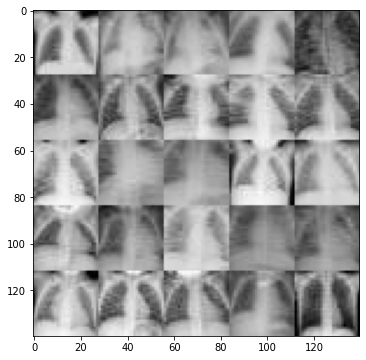

In [14]:
# montage
# source: https://github.com/MedMNIST/MedMNIST/blob/main/getting_started.ipynb
from skimage.util import montage
def process(dataset, n_channels, length=20):
    scale = length * length

    image = np.zeros((scale, 28, 28, 3)) if n_channels == 3 else np.zeros((scale, 28, 28))
    index = [i for i in range(scale)]
    np.random.shuffle(index)
    plt.figure(figsize=(6,6))

    for idx in range(scale):
        img = dataset[idx]
        if n_channels == 3:
            img = img.permute(1, 2, 0)
        else:
            img = img.reshape(28, 28)
        image[index[idx]] = img

    if n_channels == 1:
        image = image.reshape(scale, 28, 28)
        arr_out = montage(image)
        plt.imshow(arr_out, cmap='gray')
    else:
        image = image.reshape(scale, 28, 28, 3)
        arr_out = montage(image, multichannel=3)
        plt.imshow(arr_out)
    
process( x_train, n_channels=1, length=5)

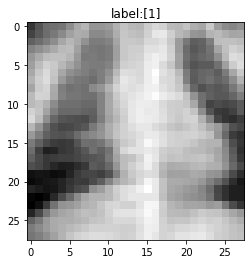

In [15]:
# visualization
import matplotlib.pylab as plt
sample_num = 99
img = x_train[sample_num].reshape(28, 28)
plt.imshow(img, cmap='gray')
template = "label:{label}"
_ = plt.title(template.format(label= str(y_train[sample_num])))
plt.grid(False)

# 搭建資料流

In [16]:
x_train.shape+(1,)

(4708, 28, 28, 1)

In [17]:
np.expand_dims(x_train, axis=3).shape

(4708, 28, 28, 1)

In [18]:
x_train = np.expand_dims(x_train, axis=3)
print('x_train shape:',x_train.shape)
x_test = np.expand_dims(x_test, axis=3)
print('x_test shape:',x_test.shape)
x_val = np.expand_dims(x_val, axis=3)
print('x_val shape:',x_val.shape)

x_train shape: (4708, 28, 28, 1)
x_test shape: (624, 28, 28, 1)
x_val shape: (524, 28, 28, 1)


In [19]:
# 將訓練資料與測試資料的 label，進行 Onehot encoding 轉換
num_classes = 2

from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
y_val_onehot = to_categorical(y_val)

print('y_train_onehot shape:', y_train_onehot.shape)
print('y_test_onehot shape:', y_test_onehot.shape)
print('y_val_onehot shape:', y_val_onehot.shape)

y_train_onehot shape: (4708, 2)
y_test_onehot shape: (624, 2)
y_val_onehot shape: (524, 2)


In [20]:
input = Input(shape=x_train.shape[1:])

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='last_conv_layer')(x)

x = GlobalAveragePooling2D(name='avg_pool')(x)
output = Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=[input], outputs=[output])

In [21]:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
last_conv_layer (Conv2D)     (None, 14, 14, 64)        36928     
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 64)               

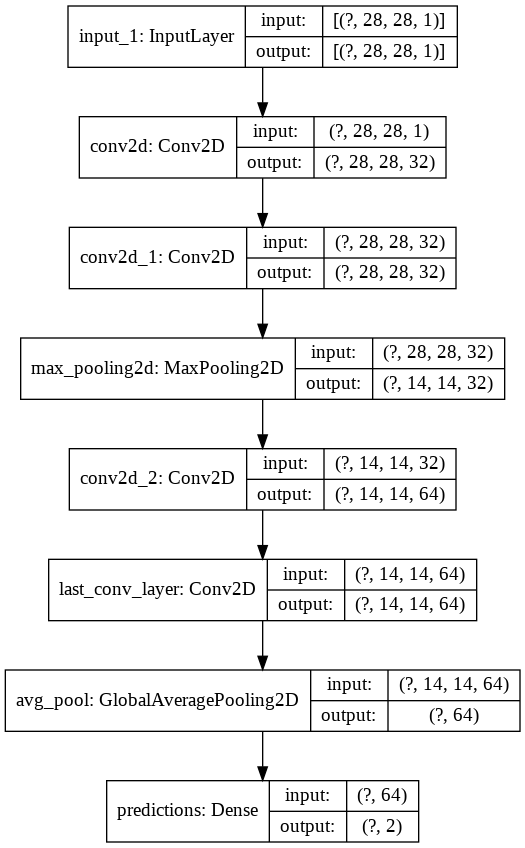

In [22]:
tf.keras.utils.plot_model(
 model,
 to_file='model_plot_CNN.png',
 show_shapes=True,
 show_layer_names=True,
 rankdir='TB',
 expand_nested=True,
 dpi=96,
)

# 模型訓練

In [23]:
# 編譯模型
# 選用 Adam 為 optimizer
from keras.optimizers import Adam

batch_size = 256
epochs = 20
init_lr = 0.001
opt = Adam(lr=init_lr)

In [24]:
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics='accuracy')

In [25]:
cnn_history = model.fit(x_train, y_train_onehot,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_val, y_val_onehot),
                  verbose=2)

Epoch 1/20
19/19 - 0s - loss: 0.5897 - accuracy: 0.7124 - val_loss: 0.5669 - val_accuracy: 0.7424
Epoch 2/20
19/19 - 0s - loss: 0.5630 - accuracy: 0.7421 - val_loss: 0.5553 - val_accuracy: 0.7424
Epoch 3/20
19/19 - 0s - loss: 0.5245 - accuracy: 0.7432 - val_loss: 0.4770 - val_accuracy: 0.7805
Epoch 4/20
19/19 - 0s - loss: 0.4508 - accuracy: 0.7782 - val_loss: 0.5743 - val_accuracy: 0.6966
Epoch 5/20
19/19 - 0s - loss: 0.4198 - accuracy: 0.8023 - val_loss: 0.3958 - val_accuracy: 0.8111
Epoch 6/20
19/19 - 0s - loss: 0.3510 - accuracy: 0.8439 - val_loss: 0.3510 - val_accuracy: 0.8244
Epoch 7/20
19/19 - 0s - loss: 0.3633 - accuracy: 0.8326 - val_loss: 0.3312 - val_accuracy: 0.8340
Epoch 8/20
19/19 - 0s - loss: 0.3442 - accuracy: 0.8511 - val_loss: 0.3482 - val_accuracy: 0.8416
Epoch 9/20
19/19 - 0s - loss: 0.3073 - accuracy: 0.8715 - val_loss: 0.2997 - val_accuracy: 0.8473
Epoch 10/20
19/19 - 0s - loss: 0.2899 - accuracy: 0.8774 - val_loss: 0.2830 - val_accuracy: 0.8531
Epoch 11/20
19/19 -

In [26]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter( y=cnn_history.history['accuracy'],
              name='Train'))
fig.add_trace(go.Scatter( y=cnn_history.history['val_accuracy'],
              name='Valid'))
fig.update_layout(height=500,width=700,
              title='Accuracy for race feature',
              xaxis_title='Epoch',
              yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

(624, 2)
[[8.3173122e-03 9.9168265e-01]
 [6.4085215e-02 9.3591481e-01]
 [7.3929322e-01 2.6070678e-01]
 [9.8813301e-01 1.1866986e-02]
 [7.8152458e-05 9.9992180e-01]]
**********************************************


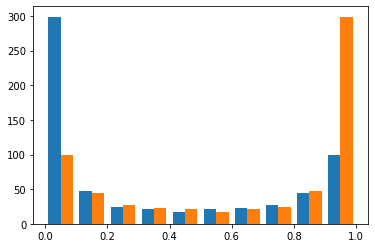

In [27]:
predictions = model.predict(x_test)
print(predictions.shape)
print(predictions[0:5])
print("**********************************************")
plt.hist(predictions)
plt.show()

(624,)
[1 1 0 0 1]
**********************************************


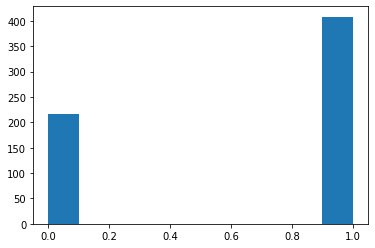

In [28]:
y_pred = np.argmax(predictions, axis=1)
print(y_pred.shape)
print(y_pred[0:5])
print("**********************************************")
plt.hist(y_pred)
plt.show()

# 模型評估

In [29]:
cnn_pred = model.evaluate(x_test, y_test_onehot, verbose=2)

20/20 - 0s - loss: 0.2691 - accuracy: 0.8942


              precision    recall  f1-score   support

      normal       0.89      0.82      0.85       234
   pneumonia       0.90      0.94      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.88      0.89       624
weighted avg       0.89      0.89      0.89       624

**************************************************************


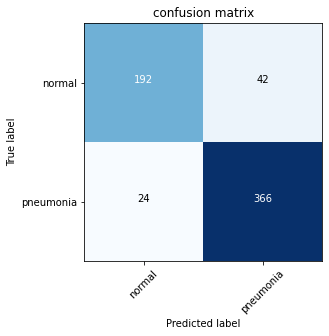

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

classes = ['normal','pneumonia']
print(classification_report(y_test, y_pred, target_names=classes))

print ("**************************************************************")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
plt.title('confusion matrix')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd' #'.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

In [31]:
y_pred[0:10], y_pred.shape

(array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0]), (624,))

In [32]:
_y_test = y_test.reshape(y_pred.shape)
_y_test[0:10], _y_test.shape

(array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0], dtype=uint8), (624,))

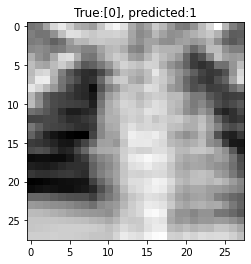

In [33]:
# visualization
import matplotlib.pylab as plt
sample_num = 1
img = x_test[sample_num].reshape(28, 28)
plt.imshow(img, cmap='gray')
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(y_test[sample_num]),
                predict= str(y_pred[sample_num])))
plt.grid(False)

# 解釋模型

**tf-keras-vis**
tf-keras-vis is a visualization toolkit for debugging tf.keras models in Tensorflow2.0+.
[github 連結](https://github.com/keisen/tf-keras-vis)

**grad-CAM**

<img src="https://github.com/keisen/tf-keras-vis/raw/master/examples/images/gradcam_plus_plus.png" alt="gradcam figure" width="700">


In [34]:
#需安裝一下套件
!pip install tf-keras-vis

In [35]:
%%time
from matplotlib import cm
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam,GradcamPlusPlus
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

def Grad_CAM_savepictures(file_index,model,save_name):
  def loss(output):
    return (output[0][y_test[file_index][0]])
  def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
  # Create Gradcam object
  gradcam = Gradcam(model,model_modifier=model_modifier,clone=False)
  originalimage=x_test[file_index]
  originalimage=originalimage.reshape((1,originalimage.shape[0],originalimage.shape[1],1))

  # Generate heatmap with GradCAM
  cam = gradcam(loss,originalimage,penultimate_layer=-1)
  cam = normalize(cam)

  #overlap image
  plt.figure(figsize=(12,8))
  ax1=plt.subplot(1, 3, 1)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(x_test[file_index].reshape((x_test.shape[1],x_test.shape[2])),cmap="gray")
  ax1.imshow(heatmap.reshape((x_test.shape[1],x_test.shape[2],3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM")

  gradcam = GradcamPlusPlus(model,model_modifier=model_modifier,clone=False)
  cam = gradcam(loss,originalimage,penultimate_layer=-1)
  cam = normalize(cam)

  ax1=plt.subplot(1, 3, 2)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(x_test[file_index].reshape((x_test.shape[1],x_test.shape[2])),cmap="gray")
  ax1.imshow(heatmap.reshape((x_test.shape[1],x_test.shape[2],3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM++")

  plt.savefig(save_name)
  plt.show()

CPU times: user 3.05 ms, sys: 0 ns, total: 3.05 ms
Wall time: 3.57 ms


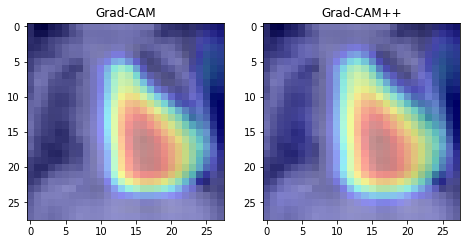

saved file - Grad-CAM_0.jpg


In [36]:
file_index = 0
Grad_CAM_savepictures( file_index, model, "Grad-CAM_{}.jpg".format(file_index))
print('saved file - Grad-CAM_{}.jpg'.format(file_index))

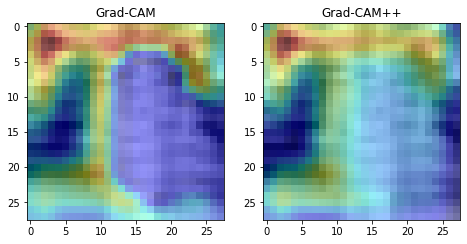

saved file - Grad-CAM_1.jpg


In [37]:
file_index = 1
Grad_CAM_savepictures( file_index, model, "Grad-CAM_{}.jpg".format(file_index))
print('saved file - Grad-CAM_{}.jpg'.format(file_index))

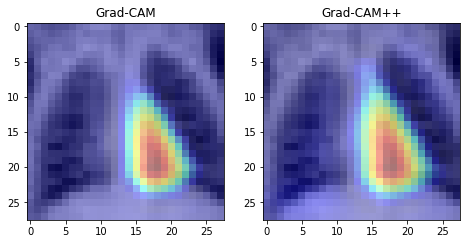

saved file - Grad-CAM_2.jpg


In [39]:
file_index = 2
Grad_CAM_savepictures( file_index, model, "Grad-CAM_{}.jpg".format(file_index))
print('saved file - Grad-CAM_{}.jpg'.format(file_index))

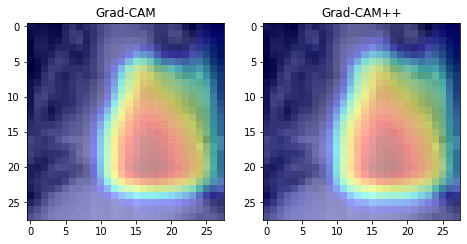

saved file - Grad-CAM_10.jpg


In [38]:
file_index = 10
Grad_CAM_savepictures( file_index, model, "Grad-CAM_{}.jpg".format(file_index))
print('saved file - Grad-CAM_{}.jpg'.format(file_index))